In [3]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

from util import util
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from sklearn.metrics import r2_score
import os

# Load data
data_folder = os.path.join('..', 'data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A Case Study for Constrained ML

I can't get no // satisfaction

## Constrained ML

**Sometimes, we _need_ ML models to satisfy certain properties**

...Regardless of how that impacts accuracy

* This may be necessary for compliance with existing regulations
* ...With ethical principles (e.g. fairness)
* ...With safety consideration
* ...Or with user expectations

**In these situations, we don't care about knowledge injection**

...But really about _constraint satisfaction_

* Constraint satisfaction is not just a tool to achieve better accuracy
* ...But a goal in its own right

> **We will refer to this setup as _Constrained ML_**

## A Case Study: Fairness in ML Models

**As a case study, say we want to estimate the risk of violent crimes**

<center><img src="assets/minority-report.jpg" width=25%/></center>

* This is obviously a very _ethically sensitive (and questionable) task_
* Our model may easily end up discriminating some social groups

## Loading and Preparing the Dataset

**We will start by loading the ["crime" UCI dataset](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)**

We will use a pre-processed version:

In [4]:
data = util.load_communities_data(data_folder)
attributes = data.columns[3:-1]
target = data.columns[-1]
data.head()

,communityname,state,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
1008,EastLampetertownship,PA,5,11999,0,0.1203,0.2544,0.1208,0.1302,0.5776,...,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000,147.49
1271,EastProvidencecity,RI,6,50380,0,0.1171,0.2459,0.1159,0.1660,1.0000,...,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000,150.88
1936,Betheltown,CT,9,17541,0,0.1356,0.2507,0.1138,0.0804,0.8514,...,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000,95.47
1601,Crowleycity,LA,8,13983,0,0.1506,0.2587,0.1234,0.1302,0.0000,...,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000,1029.02
293,Pawtucketcity,RI,2,72644,0,0.1230,0.2725,0.1276,0.1464,1.0000,...,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103,458.28


The target is "violentPerPop" (number of violent offenders per 100K people)

## Loading and Preparing the Dataset

**We prepare for normalizing all numeric attributes**

* The only categorical input is "race" (0 = primarily "white", 1 = primarily "black")
* Incidentally, "race" is _a natural focus to check for discrimination_

**We define the train-test divide and we identify the numerical inputs**

In [5]:
tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
nf = [a for a in attributes if a != 'race'] + [target]

We normalize the data and convert to float32 (to make TensorFlow happier)

In [6]:
tmp = data.iloc[:tr_sep]
scale = tmp[nf].max()
sdata = data.copy()
sdata[nf] /= scale[nf]

sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

## Loading and Preparing the Dataset

**Finally we can separate the training and test set**

In [7]:
tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]
tr.describe()

,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,medIncome,pctWwage,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
count,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,...,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,5.515056,0.007309,0.031995,0.266962,0.398600,0.230577,0.226739,0.695383,0.272795,0.808877,...,0.126063,0.649191,0.651699,0.796561,0.886649,0.009499,0.062829,0.057092,0.021317,0.118508
std,2.912637,0.030287,0.176042,0.084005,0.090329,0.098553,0.091256,0.445105,0.108972,0.081297,...,0.144243,0.183083,0.135358,0.112796,0.077034,0.028955,0.065060,0.092881,0.061344,0.123444
min,1.000000,0.001368,0.000000,0.084191,0.134635,0.075644,0.031457,0.000000,0.104413,0.327882,...,0.003182,0.072472,0.150586,0.289367,0.332187,0.000335,0.000226,0.000000,0.000000,0.001097
25%,3.000000,0.001943,0.000000,0.225230,0.350689,0.185238,0.167614,0.000000,0.190973,0.759677,...,0.035541,0.525016,0.566446,0.743167,0.854675,0.002754,0.026280,0.006672,0.000000,0.032800
50%,5.000000,0.003035,0.000000,0.250919,0.385173,0.205575,0.223138,1.000000,0.249509,0.813755,...,0.075352,0.669369,0.658096,0.819391,0.905697,0.005099,0.045234,0.022823,0.000000,0.076430
75%,8.000000,0.005922,0.000000,0.283824,0.419908,0.235735,0.275298,1.000000,0.334641,0.866125,...,0.155517,0.798529,0.744017,0.875764,0.938556,0.009667,0.074085,0.064651,0.000000,0.159716
max,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline

**Let's establish a baseline by tackling the task via Linear Regression**

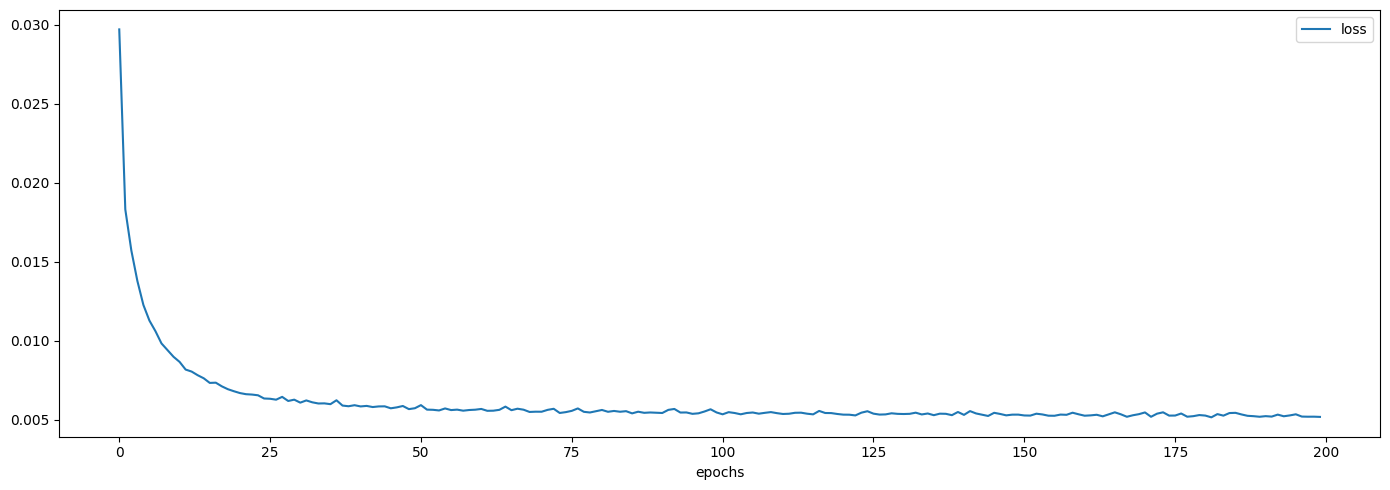

Model loss: 0.0052 (training)


In [8]:
nn = util.build_ml_model(input_size=len(attributes), output_size=1, hidden=[])
history = util.train_ml_model(nn, tr[attributes], tr[target], validation_split=0., epochs=200)
util.plot_training_history(history, figsize=figsize)

## Baseline Evaluation

**...And let's check the results**

In [10]:
tr_pred = nn.predict(tr[attributes], verbose=0)
r2_tr = r2_score(tr[target], tr_pred)

ts_pred = nn.predict(ts[attributes], verbose=0)
r2_ts = r2_score(ts[target], ts_pred)

print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')

R2 score: 0.66 (training), 0.59 (test)


* They are not super (definitely not [PreCrime](https://en.wikipedia.org/wiki/The_Minority_Report) level), but not alwful either
* Some improvements (not much) can be obtained with a Deeper model

**We will keep Linear Regression as a baseline**

## Discrimination Indexes

**Discrimination can be linked to _disparate treatment_**

* "race" _may not be even among the input attributes_
* ...And yet it may be taken into account implicitly (i.e. via correlates)

**But we can check whether the model _treats differently different groups_:**


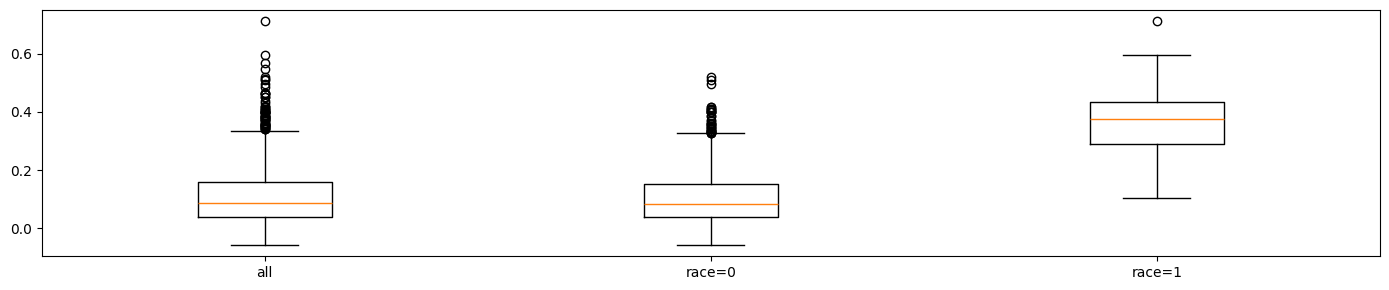

In [12]:
protected = {'race': (0, 1)}
util.plot_pred_by_protected(tr, tr_pred, protected, figsize=(figsize[0], 0.6*figsize[1]))

Indeed, our model has a significant degree of discrimination

## Discrimination Indexes

**A number of _discrimination indexes_ attempt to measure discrimination**

* Whether ethics itself can be measured is _highly debatable_!
* ...But even if imperfect, this currently the best we can do

**We will use the [Disparate Impact Discrimination Index](https://www.aaai.org/ojs/index.php/AAAI/article/download/3943/3821)**

* Given a set of categorical _protected attribute (indexes) $J_p$_
* ...The regression for of the regression form of the index ($\text{DIDI}_r$) is given by:

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* Where $D_j$ is the domain of attribute $j$
* ...And $I_{j,v}$ is the set of example such that attribute $j$ has value $v$




## DIDI

**Let's make some intuitive sense of the $\text{DIDI}_r$ formula**

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* $\frac{1}{m} \sum_{i=1}^m y_i$ is just the average predicted value
* The protected attribute defines social groups
* $\frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}$ is the average prediction for a social group

**We penalize _deviations from the global average_**

* Obviously this is not necessarily the best definition, but it is something
* In general, different tasks will call for different discrimination indexes

...And don't forget the whole "can we actually measure ethics" issue ;-)

## DIDI

**We can compute the DIDI via the following function**

```python
def DIDI_r(data, pred, protected):
    res, avg = 0, np.mean(pred)
    for aname, dom in protected.items():
        for val in dom:
            mask = (data[aname] == val)
            res += abs(avg - np.mean(pred[mask]))
    return res
```

* `protected` contains the protected attribute names with their domain

**For our original Linear Regression model, we get**

In [13]:
tr_DIDI = util.DIDI_r(tr, tr_pred, protected)
ts_DIDI = util.DIDI_r(ts, ts_pred, protected)
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

DIDI: 0.26 (training), 0.28 (test)


## Fairness Constraints

**Discrimination indexes can be used to state _fairness constraints_**

For example, we may require:
$$
\text{DIDI}_r(\hat{y}) \leq \varepsilon  \quad \text{ with: } \hat{y} = f(x; \theta)
$$

* Where $f$ is a ML model

**Fairness constraints are an example of _distribution constraint_**

...Since they specify desired properties for a _statistical distribution_

* Since most distributions are now known in analytical form
* ...Enforcing these kind of constraint exactly is very difficult

**In practice, _Monte-Carlo approximations_ are typically employed**

In our example, the DIDI uses a Monte-Carlo approximation for expectations